# Andor Full Vertical Binning for Resolving Single Photon O2 Fluorescence 

## Intro

Modifications to Data Acquisition (DAQ) system to enable data collection with slow cameras increases the number of configurations that prevent the DAQ from operating.  The goal here is to show that O2 photons can be identified in higher level noise present during full vertical binning by using fourier domain filtering to digitally attenuate the readout noise.

This was demoed on a Cu data with andor in full vertical binning set to show improved SNR

## Loading Libraries

In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter

## Initializing Data

### Loading Data

In [274]:
#load data
experiment_run_name = "xpptut15run360.h5"       #this contains
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")

### Converting hdf5 to Python Dictionary

In [233]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    try:
        my_dict[i] = array(my_hdf5_object[i])
    except:
        pass

In [234]:
 my_dict['andor/image/orig'] = 0+ my_dict['andor/image']

In [238]:
#removing offsets
my_dict['andor/image'] = my_dict['andor/image/orig'][0]-mean(my_dict['andor/image/orig'][0][:100])
for i in arange(1,len(my_dict['andor/image'])):
    #my_dict['andor/image'][i]=my_dict['andor/image/orig'][i]- mean(my_dict['andor/image/orig'][i][:100])
    my_dict['andor/image'] = vstack([my_dict['andor/image'] ,my_dict['andor/image/orig'][i]-mean(my_dict['andor/image/orig'][i][:100])])

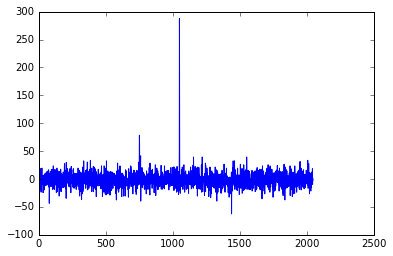

In [239]:
plot(my_dict['andor/image/orig'][100]-mean(my_dict['andor/image/orig'][100][:100]))
show()

## Visualizing Some Sample Data

### some single shots

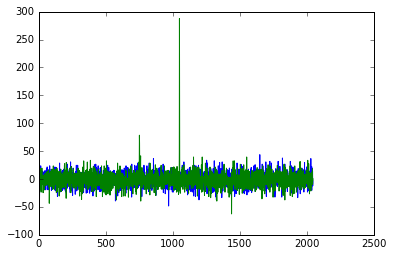

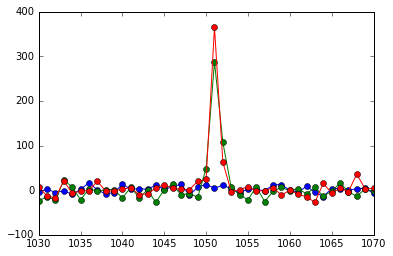

In [240]:
#plot some sample data
plot(my_dict['andor/image'][0])
plot(my_dict['andor/image'][100])
show()
plot(my_dict['andor/image'][0],'o-')
plot(my_dict['andor/image'][100],'o-')
plot(my_dict['andor/image'][200],'o-')
xlim(1030,1070)
show()

## Histogram of photon intensities

### comparing with signal vs thresholded noise

In [241]:
def outlier_removal(y,window_size):
    #smoothed = convolve(y,ones(window_size)*1.0/window_size,mode="same")
    smoothed = medfilt(y,window_size)
    stan_dev = std(y-smoothed)

    to_return = []
    for i in arange(len(y)):
        if (abs(y[i]-smoothed[i])>2.5*stan_dev):
            #to_return.append(smoothed[i])
            to_return.append(-9)
        else:
            to_return.append(y[i])
    return to_return

In [242]:
window_size = 11
my_noise = outlier_removal(my_dict['andor/image'].flatten(),window_size)   #just looking at the noise

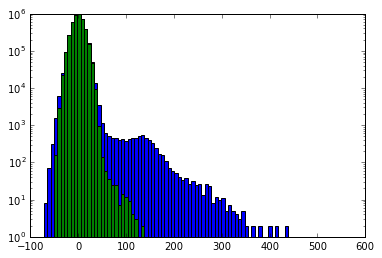

In [244]:
hist(my_dict['andor/image'].flatten(),bins=arange(-100,600,7),log=True)
hist(my_noise,bins=arange(-100,600,7),log=True)
show()

### comparing fourier filtered histogram with regular histogram

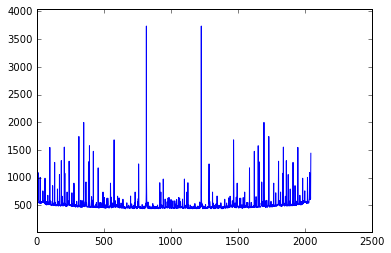

In [245]:
#find location of of largest noise term
my_power_spectrum = mean(abs(fft(my_dict['andor/image'],axis=1)), axis=0)
plot(my_power_spectrum)
ylim(e**3,0.5*e**9)
show()

In [246]:
n_events=1000
fourier_filter_images = fft(my_dict['andor/image'],axis=1)
for i in arange(n_events):
    temp_power_spectrum = mean(abs(fourier_filter_images[:n_events]), axis=0)
    my_arg_max = argmax(temp_power_spectrum)
    my_max = temp_power_spectrum[my_arg_max]
    #print(my_arg_max)
    #print(my_max)
    #print(i)
    
    fourier_filter_images[:,my_arg_max] *=500.0/my_max
    fourier_filter_images[:,len(my_power_spectrum)-my_arg_max-1] *=500.0/my_max

corrected_image = real(ifft(fourier_filter_images,axis=1))


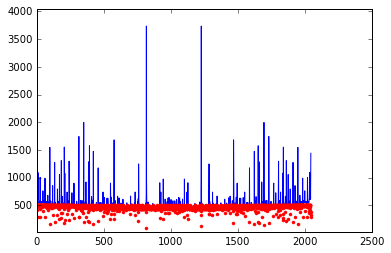

In [248]:
plot(mean(abs(fft(my_dict['andor/image'],axis=1)), axis=0),'b-')
plot(temp_power_spectrum,'r.')
ylim(e**3,0.5*e**9)
show()

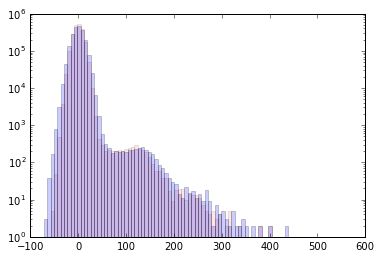

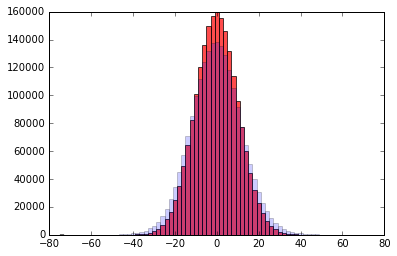

In [326]:
bin_start = -100
bin_end= 600
hist(corrected_image[:n_events].flatten(),bins=arange(bin_start,bin_end,7),log=True,alpha=0.1,color='r')
hist(my_dict['andor/image'][:n_events].flatten(),bins=arange(bin_start,bin_end,7),log=True,alpha=0.2)
show()

hist(corrected_image[:n_events].flatten(),bins=arange(-75,75,2),alpha=0.7,color='r')
hist(my_dict['andor/image'][:n_events].flatten(),bins=arange(-75,75,2),alpha=0.2)

show()


In [273]:
print(std(my_noise))
print(std(outlier_removal(corrected_image[:n_events].flatten(),window_size)))
#print(std(corrected_image[:n_events].flatten()))

11.8214166281
9.95250575571


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


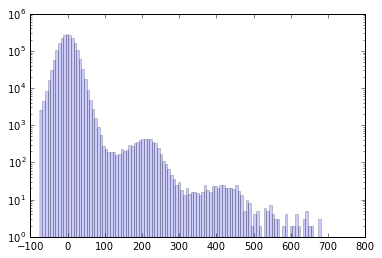

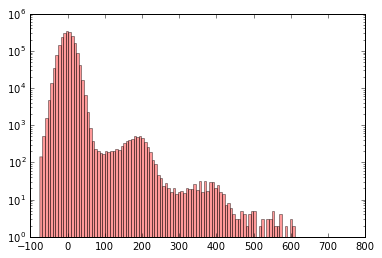

In [324]:
window_size = 3.0
pseudo_large_pixel = convolve(corrected_image[:n_events].flatten(),ones(window_size))
hist(convolve(my_dict['andor/image'][:n_events].flatten(),ones(window_size)),bins=arange(-75,750,7),alpha=0.2,log=True)

show()

hist(pseudo_large_pixel,bins=arange(-75,750,7),alpha=0.4,color='r',log=True)

show()


## comparing effects of thresholding on photon count

### Brute Force Sum

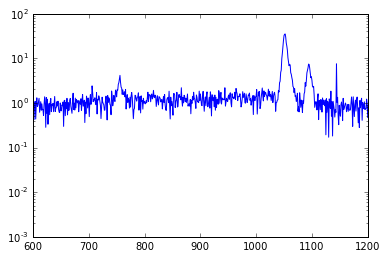

In [290]:
plot(1+mean(my_dict['andor/image'],axis=0))
semilogy()
xlim(600,1200)
show()

### Thresholded sum

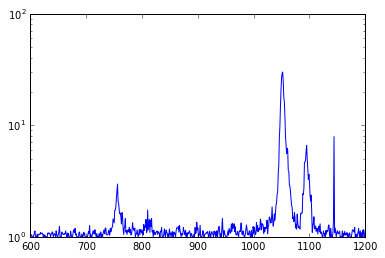

In [289]:
threshold_mask = my_dict['andor/image']<70
thresholded_data = 0+ my_dict['andor/image']
thresholded_data[threshold_mask]=0
plot(1+mean(thresholded_data,axis=0))
semilogy()
xlim(600,1200)
show()

### Fourier corrected and thresholded sum

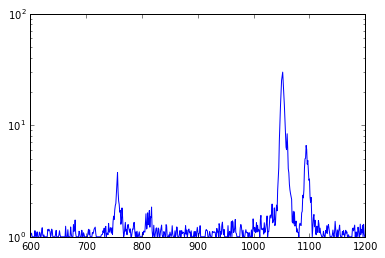

In [300]:
#plot(2+mean(corrected_image[:n_events],axis=0))

threshold_mask = corrected_image[:n_events]<40
thresholded_data = 0+ corrected_image[:n_events]
thresholded_data[threshold_mask]=0

plot(1+mean(thresholded_data,axis=0))

semilogy()
xlim(600,1200)
show()